In [67]:
import cv2
import numpy as np
from skimage import color, data, io, measure
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
mpl.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi']= 300
plt.rc("savefig", dpi=300)

In [60]:
img = cv2.imread("./images/764303_0000FISH 120 GM.jpg",0 )
img


array([[87, 87, 87, ..., 87, 87, 87],
       [87, 87, 87, ..., 87, 87, 87],
       [87, 87, 87, ..., 87, 87, 87],
       ...,
       [87, 87, 87, ..., 87, 87, 87],
       [87, 87, 87, ..., 87, 87, 87],
       [87, 87, 87, ..., 87, 87, 87]], dtype=uint8)

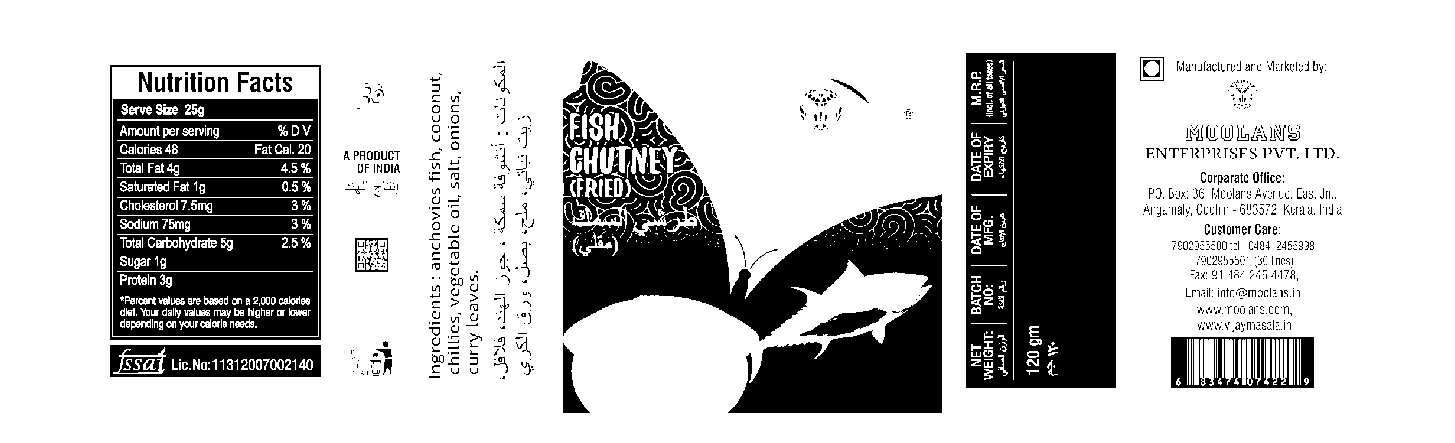

In [61]:
# Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 240, 255,cv2.THRESH_BINARY,cv2.THRESH_OTSU)
# print(img_bin)
# print(thresh)
# Invert the image
img_bin = 255-img_bin 
cv2.imwrite("img_bin.jpg",img_bin)
plt.axis('off')
plt.imshow(img_bin);


(thresh, ap) = cv2.threshold(img, 240, 255,cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin 
#cv2.imwrite("img_bin.jpg",img_bin)
plt.axis('off')
plt.imshow(img_bin);

In [62]:
def f(y):
    # Defining a kernel length
    global horizontal_lines_img, verticle_lines_img, kernel
    kernel_length = np.array(img).shape[1]//y

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    ###kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=1)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=1)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=1)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=1)
    ###plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
    ###plt.imshow(verticle_lines_img);
    ###plt.axis('off')

    ###plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
    plt.imshow(horizontal_lines_img);
    plt.axis('off')


interact(f,  y=widgets.IntSlider(min=0,max=450,step=2,value=450));

interactive(children=(IntSlider(value=450, description='y', max=450, step=2), Output()), _dom_classes=('widget…

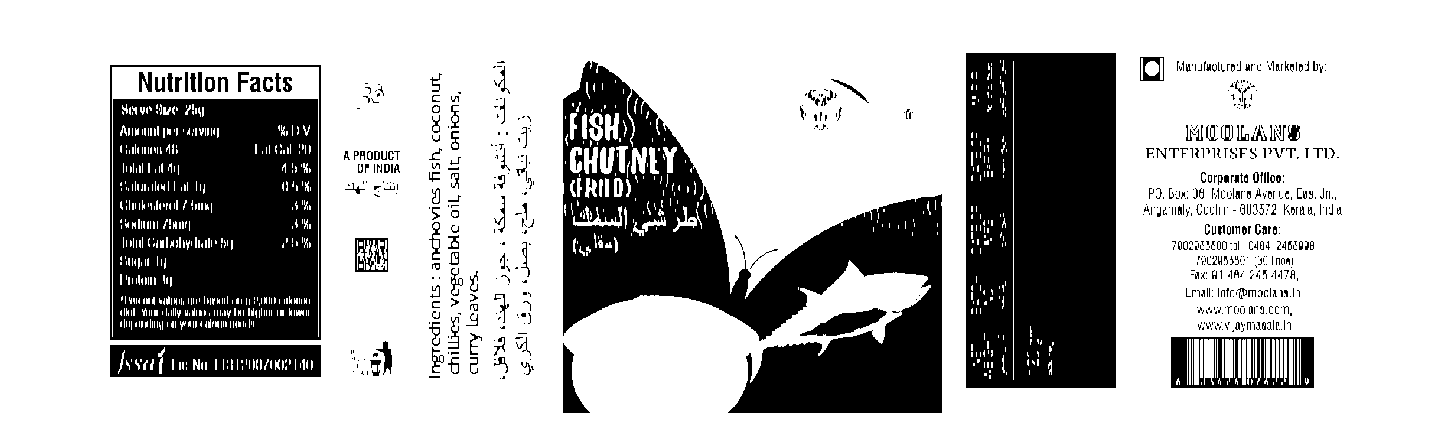

In [63]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.9
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.5)
#img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(img_final_bin)

In [64]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = False

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "right-to-left":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

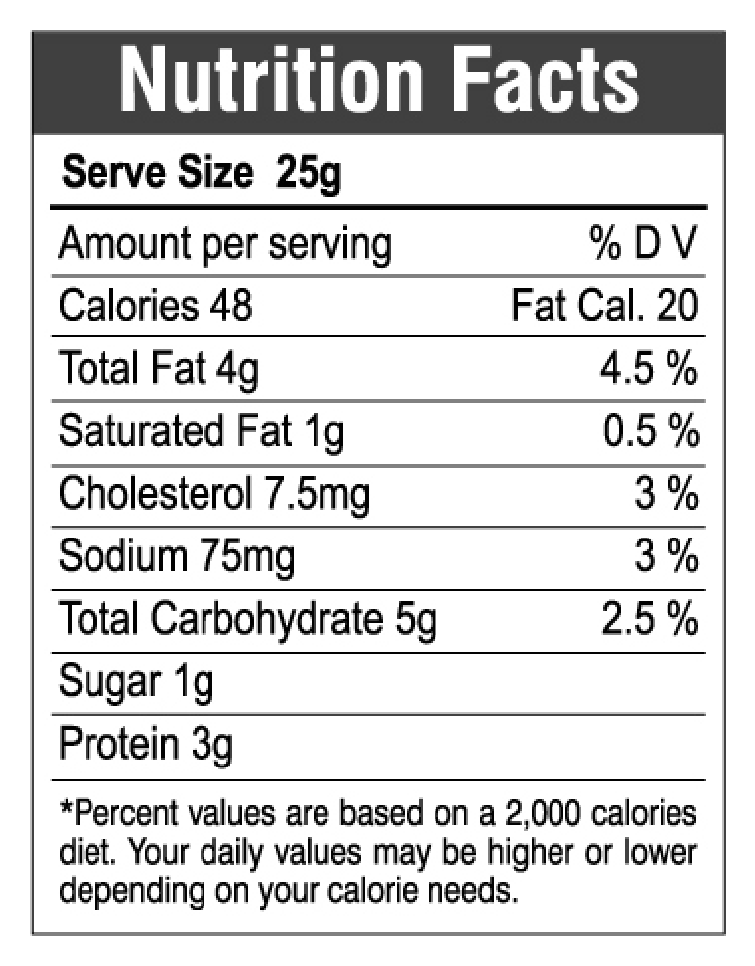

In [65]:
idx = 1
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
    if (w > 160 and h > 80) and w <= 1.5 *h:
        idx += 3
        new_img = img[y:y+h, x:x+w]
        #plt.subplot(10,1, idx)
        plt.imshow(new_img)
        plt.axis('off')
        plt.savefig('test_result.png',dpi=300)

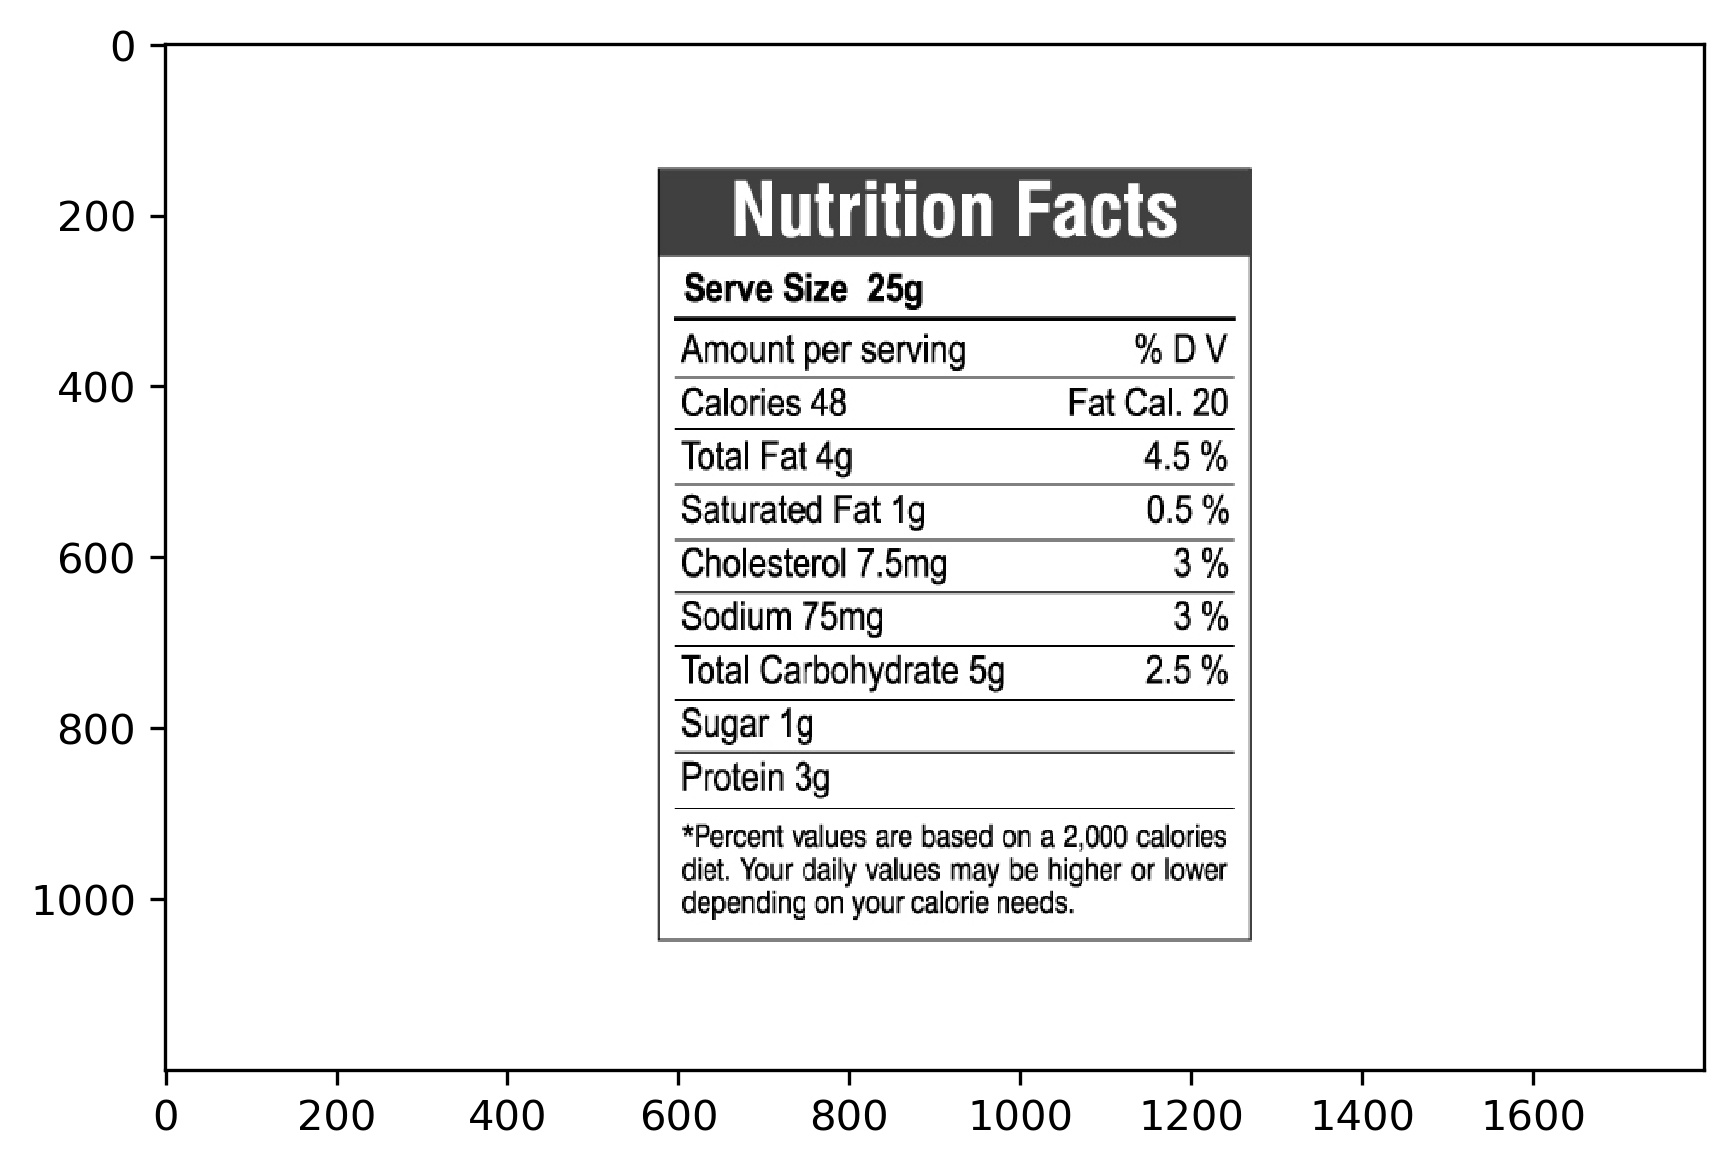

In [68]:
io.imshow('./test_result.png')

In [69]:
def show_image_contour(image, contours):
    plt.figure()
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
    plt.imshow(image, interpolation='nearest', cmap='gray_r')
    plt.title('Contours')
    plt.axis('off')
    plt.show()

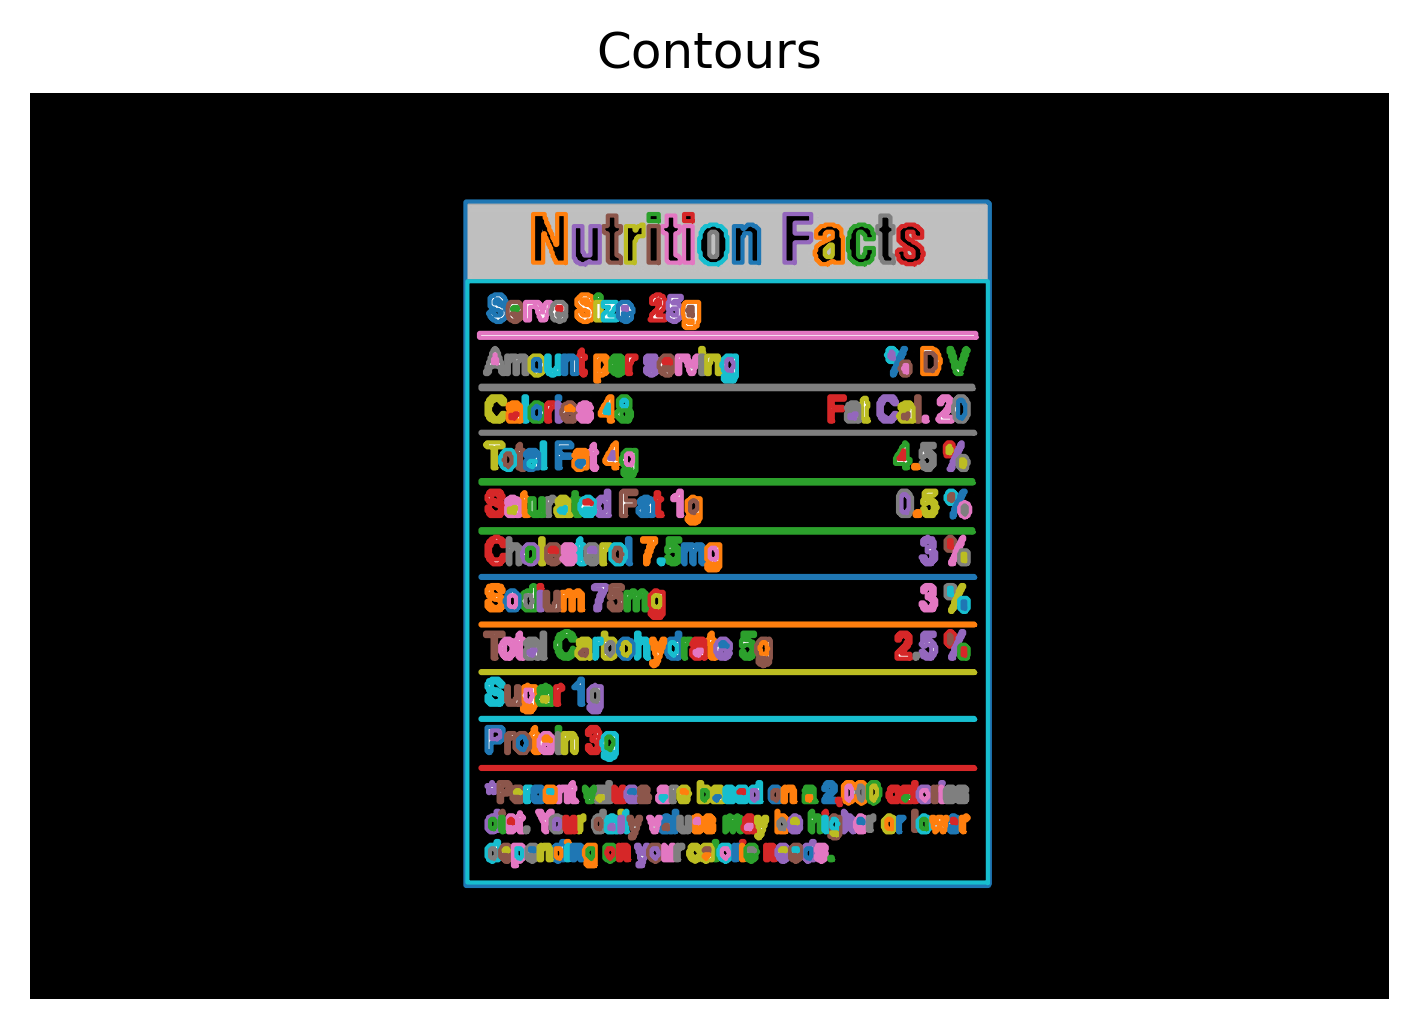

Letters' number: 117. 


<Figure size 1800x1200 with 0 Axes>

In [77]:
# Find contours at a constant value of 0.8



test_result = io.imread('./test_result.png')

#contours = measure.find_contours(binary_global, 0.8)

# Make the image grayscale
test_result = color.rgb2gray(test_result)

# Obtain the optimal thresh value
thresh = threshold_otsu(test_result)

binary = test_result > thresh

contours = measure.find_contours(binary, 0.8)

# Show the image
show_image_contour(test_result, contours)

# Print the dice's number
print("Letters' number: {}. ".format(len(dots_contours)))
plt.savefig('contour_result2.png')

#### Grouping individual Cont.

# let's now draw the contour
a1, arr_cnt, a2 = cv2.findContours(binary, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# let's copy the example image, so we don't paint over it
img_with_allcontours=new_img.copy()

cv2.drawContours(img_with_allcontours, arr_cnt, -1, (0,255,0), 3)
previewImg('Contours',img_with_allcontours)

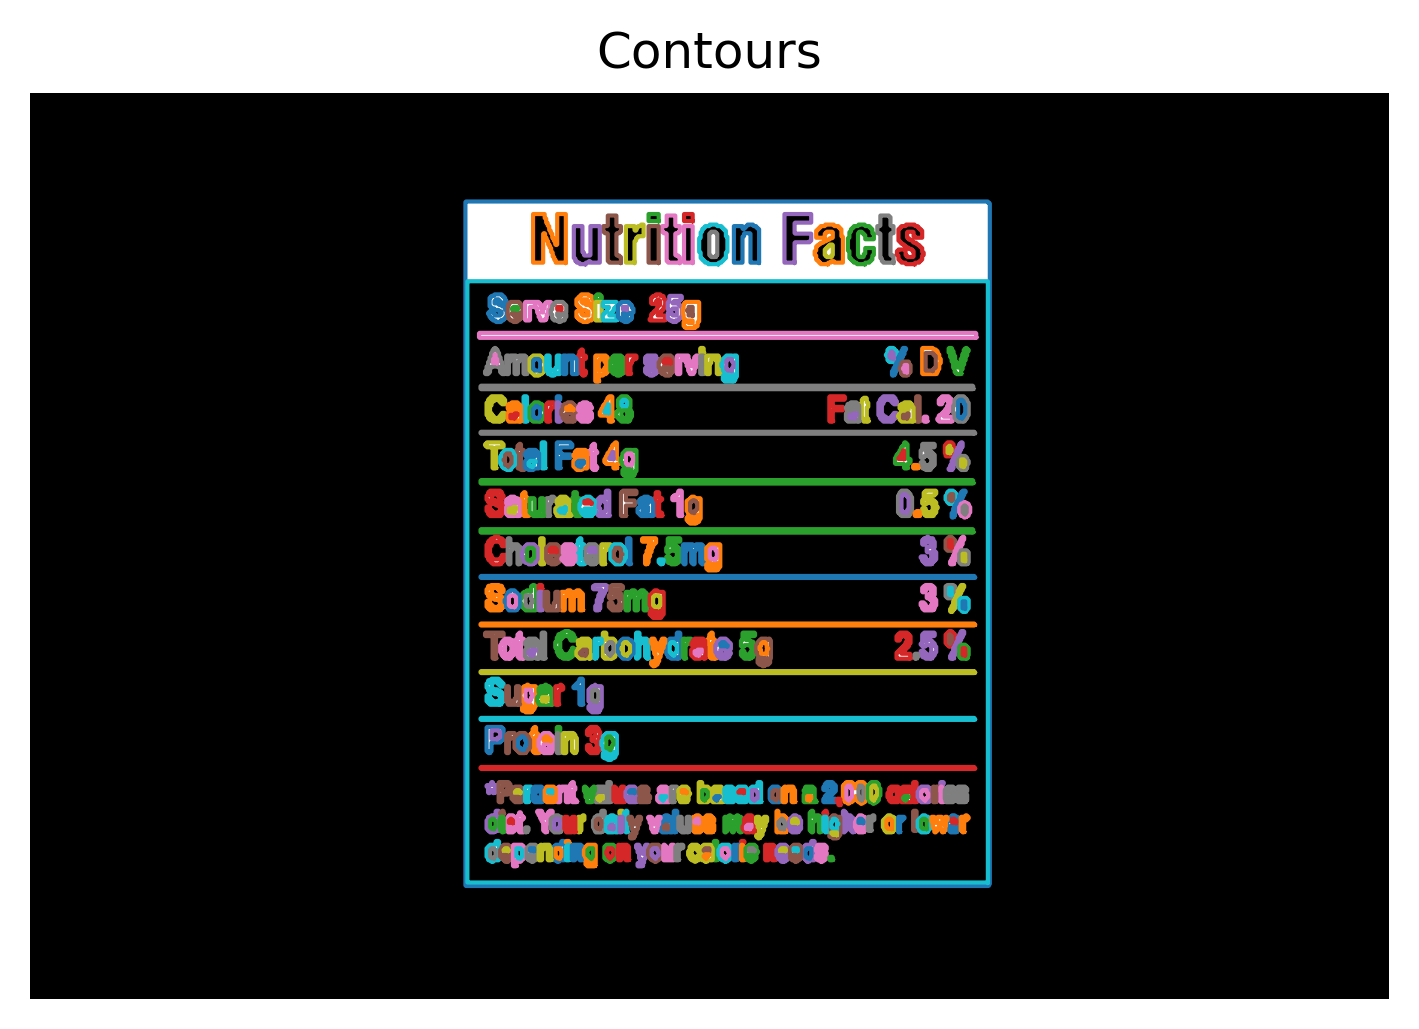

Letters' number: 117. 


In [72]:

# Create list with the shape of each contour 
shape_contours = [cnt.shape[0] for cnt in contours]

# Set 50 as the maximum size of the dots shape
max_dots_shape = 50

# Count dots in contours excluding bigger than dots size
dots_contours = [cnt for cnt in contours if np.shape(cnt)[0] < max_dots_shape]

# Shows all contours found 
show_image_contour(binary, contours)


# Print the dice's number
print("Letters' number: {}. ".format(len(dots_contours)))

### Extracting text from Nutrition lables

In [73]:

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

#### Method 1

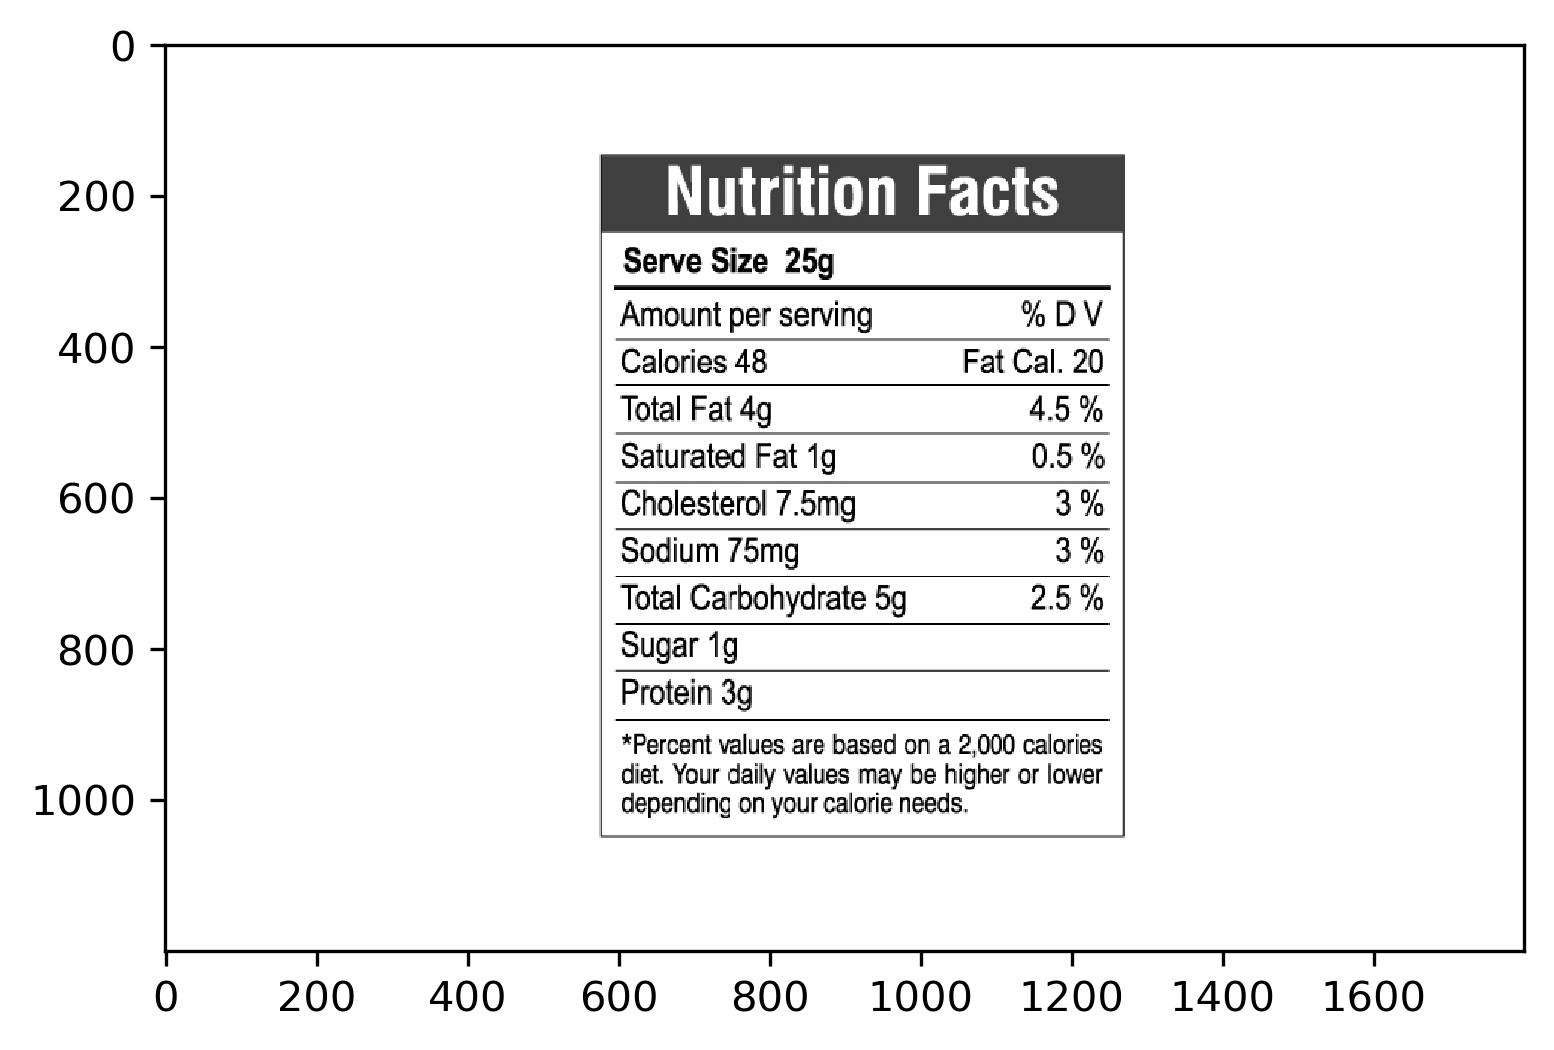

In [74]:
imb = Image.open('./test_result.png')
plt.imshow(imb)

In [75]:

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter

im = Image.open("test_result.png") # the second one 
im = im.filter(ImageFilter.MedianFilter())
enhancer = ImageEnhance.Contrast(im)
im = enhancer.enhance(22)
im = im.convert('1')
im.save('test2.jpg')

text = pytesseract.image_to_string(Image.open('test2.jpg'))
print(text)

Nutrition Facts
Serve Size 25g

Amount per serving %DV
Calories 48 Fat Cal. 20

 

Total Fat 4g 45%
Saturated Fat 1g 0.5%

Cholesterol 7.5mg 3%
Sodium 75mg 3%

 

Total Carbohydrate 5g 2.5%

 

Sugar 1g
Protein 3g

 

*Percent values are based on a 2,000 calories
diet. Your dally values may be higher or lower
depending on your calorie needs.


#### Method 2

In [76]:
# A seconde way to extract text - OCR 
import os
import tempfile
import subprocess

def ocr(path):
    temp = tempfile.NamedTemporaryFile(delete=False)

    process = subprocess.Popen(['tesseract', path, temp.name], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    process.communicate()

    with open(temp.name + '.txt', 'r') as handle:
        contents = handle.read()

    os.remove(temp.name + '.txt')
    os.remove(temp.name)

    return contents

str = ocr('test_result.png')
print(str)

 

 

 

 

 

 

 

 

 

 

Serve Size 25g

Amount per serving %DV
Calories 48 Fat Cal. 20
Total Fat 4g 4.5%
Saturated Fat 1g 0.5 %
Cholesterol 7.5mg 3%
Sodium 75mg 3%
Total Carbohydrate 5g 2.5 %
Sugar 1g

Protein 3g

*Percent values are based on a 2,000 calories
diet. Your daily values may be higher or lower
depending on your calorie needs.

 

 

 

